In [91]:
# Importing the libraries
import json

import numpy as np
import pandas as pd
import scipy

import seaborn as sns
import matplotlib.pyplot as plt

# Algorithm Evaluation
This notebook aims to evaluate different algorithms by comparing them to the ground truth and compare them against each other.

In [93]:
def create_binary_list(indices, total_length):
    """
    Create a binary list where indices are marked as 1s.
    """
    binary_list = [0] * (total_length+1)
    for index in indices:
        binary_list[index] = 1
    return binary_list

def calculate_rate_of_agreement(list1, list2):
    """
    Calculate the rate of agreement between two lists of spike indices.
    """
    total_indices = len(list1)+len(list2)
    max_length = max(list1[-1], list2[-1])
    max_agreement = 0
    best_shift = 0
       # Create binary lists for list1 and list2
    binary_list1 = create_binary_list(list1, max_length)
    binary_list2 = create_binary_list(list2, max_length)


    # Iterate through possible shifts
    for shift in range(-75, 75):
        agreement_count = 0

        # Shift binary_list1 by shift amount
        shifted_binary_list1 = [0] * max_length
        if shift < 0:
            shifted_binary_list1[-shift:] = binary_list1[:shift]
        elif shift > 0:
            shifted_binary_list1[:-shift] = binary_list1[shift:]


 
        # Perform element-wise multiplication and sum
        for i in range(max_length):
            agreement_count += shifted_binary_list1[i] * binary_list2[i]

        # Calculate rate of agreement for current shift
        rate_of_agreement = (agreement_count * 2 / total_indices) * 100

        # Update max agreement and best shift if current shift has higher rate of agreement
        if rate_of_agreement > max_agreement:
            max_agreement = rate_of_agreement
            best_shift = shift

    return best_shift, max_agreement

In [94]:
def compare_algorithms(MUPulsesA, MUPulsesB):
    roa_matrix = pd.DataFrame(0.0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
    shift_matrix = pd.DataFrame(0.0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

    spikeCountTrue = []
    spikeCountCalc = []

    print(roa_matrix.shape)
    loopidx = 0
    # Looping through the sources A and sources B and computing their mutual rate of agreement.
    for idxA, sourceA in enumerate(MUPulsesA):
        spikeCountTrue.append(len(sourceA))
        for idxB, sourceB in enumerate(MUPulsesB):
            print(f"Progress: {idxA, idxB}\r", end="", flush=True)
            if loopidx <1:
                spikeCountCalc.append(len(sourceB))

            shift, rate_of_agreement = calculate_rate_of_agreement(sourceA, sourceB)
            
            roa_matrix.iloc[idxA, idxB] = rate_of_agreement 
            shift_matrix.iloc[idxA, idxB] = shift 

    loopidx = 1
    print("\nDone.")
    return roa_matrix#, shift_matrix

## Fetching the Data

In [95]:
# Fetch the true sources
file_path = '../data/SIMULATION_56_40.mat'
# Create a dictionary from the matlab data file.
data_dict = scipy.io.loadmat(file_path)

# Extract the EMG spike data into a numpy array
TrueMUPulses = np.array(data_dict['MUPulses'][0])
TrueMUPulses = [subarray[0] for subarray in TrueMUPulses]
print(len(TrueMUPulses))

56


In [98]:
# Fetch Matlab sources
file_path_mat = '../data/matlabSpikes50.mat'
# Create a dictionary from the matlab data file.
data_dict_mat = scipy.io.loadmat(file_path_mat)

# Extract the EMG spike data into a numpy array
MUPulsesMat = np.array(data_dict_mat['spikeMat'])

MatlabMUPulse = []
for idx in range(len(MUPulsesMat)):
    sourceList = []
    for index, value in enumerate(MUPulsesMat[idx]):
        if value == 1:
            sourceList.append(index)
    MatlabMUPulse.append(sourceList)
print(len(MatlabMUPulse))

14


In [99]:
# Opening JSON file
f = open('../data/output2.json')
# returns JSON object as a dictionary
PythonMUPulses = json.load(f)
 # Closing file
f.close()#
PythonMUPulses = PythonMUPulses[1]['sources']
PythonMUPulses = [subarray['SpikeTrain'] for subarray in PythonMUPulses]
print(len(PythonMUPulses))

14


## Comparing the Algorithms

In [100]:
py_roa_matrix = compare_algorithms(TrueMUPulses, PythonMUPulses)
mat_roa_matrix = compare_algorithms(TrueMUPulses, MatlabMUPulse)
pymat_roa_matrix = compare_algorithms(MatlabMUPulse, PythonMUPulses)

(56, 14)
Progress: (55, 13)
Done.
(56, 14)
Progress: (55, 13)
Done.
(14, 14)
Progress: (13, 13)
Done.


## Plotting the Results

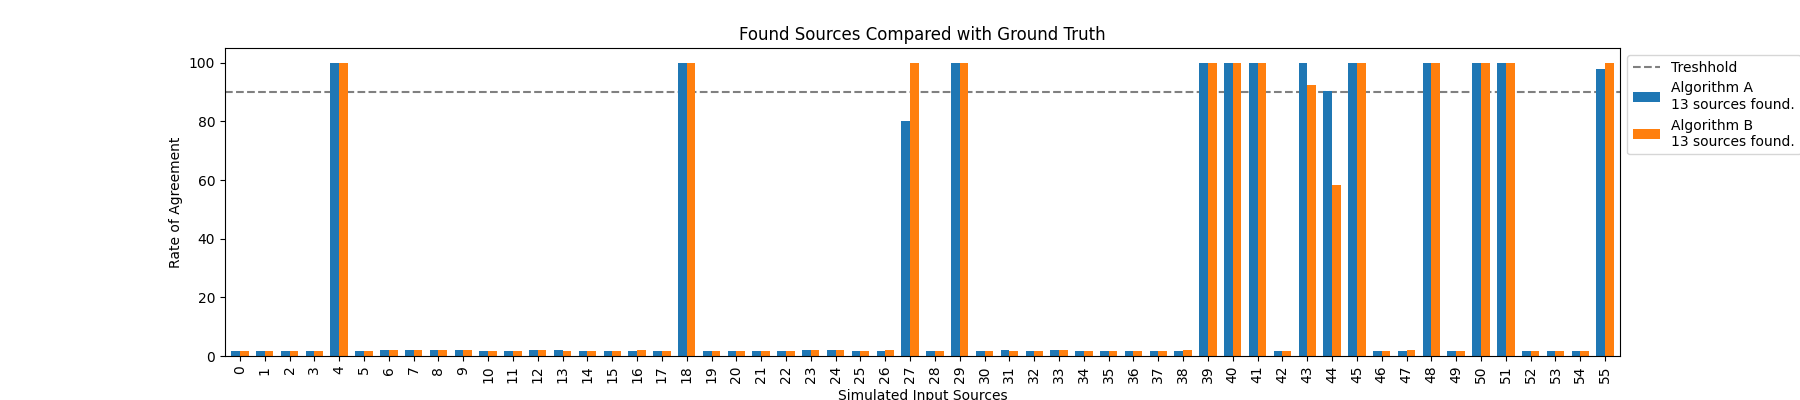

In [106]:
comparision_mx = pd.DataFrame()
comparision_mx['Algorithm A']= py_roa_matrix.max(axis=1)
comparision_mx['Algorithm B'] = mat_roa_matrix.max(axis=1)
#print(comparision_mx)


max_a = py_roa_matrix.max(axis=0)
max_b = mat_roa_matrix.max(axis=0)
# Create a DataFrame
comparisionb_mx = pd.DataFrame({'Algorithm A': max_a, 'Algorithm B': max_b})
# Reindex the DataFrame to align indices
comparisionb_mx = comparisionb_mx.reindex(range(max(len(max_a), len(max_b))))
# Fill missing values with 0
comparisionb_mx.fillna(0, inplace=True)
#print(comparisionb_mx)

#print(pymat_roa_matrix.iloc[:, 5:17])

ax = comparision_mx.plot.bar(figsize=(18,4), width = 0.7)

plt.axhline(y=90, color='grey', linestyle='--', label= 'Treshhold',  zorder=0)
plt.legend( loc='upper left', labels=['Treshhold', f'Algorithm A\n{len(comparision_mx[comparision_mx['Algorithm A']>90])} sources found.', f'Algorithm B\n{len(comparision_mx[comparision_mx['Algorithm B']>90])} sources found.'], bbox_to_anchor=(1, 1))

plt.xlabel('Simulated Input Sources')
plt.ylabel('Rate of Agreement')
plt.title('Found Sources Compared with Ground Truth')
plt.show()

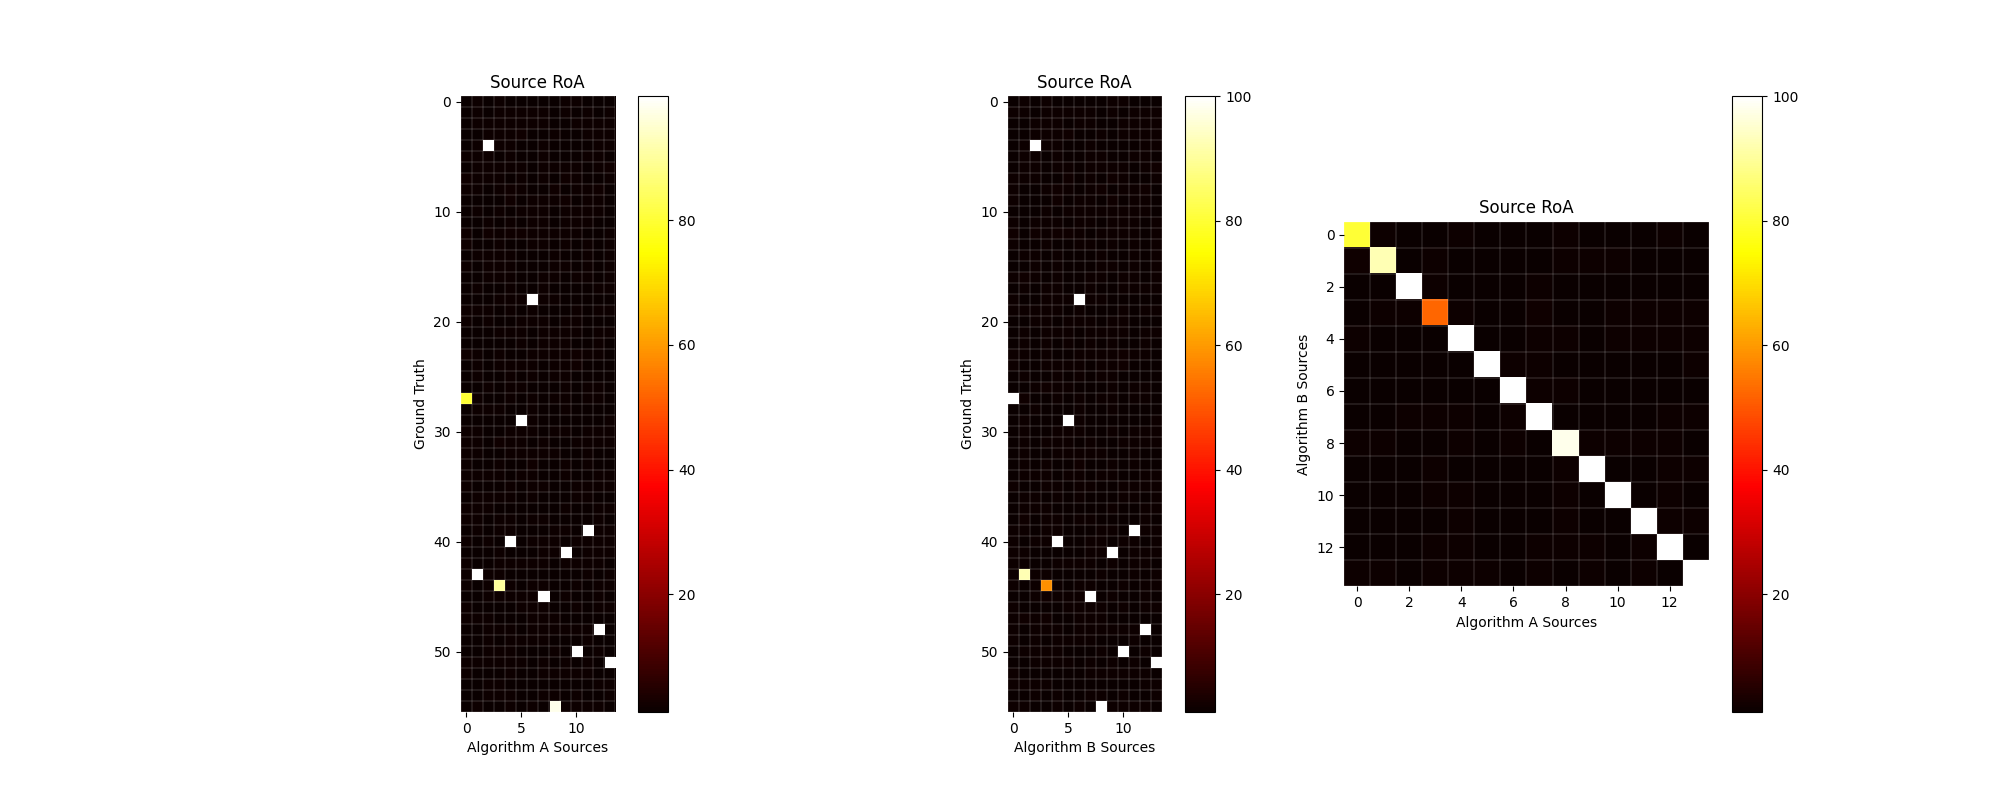

In [104]:
# Step 3: Plot the Heatmap
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))


plot1 = ax1.imshow(py_roa_matrix, cmap='hot', interpolation='nearest')
# Step 4: Customize the Plot (Optional)
ax1.set_xlabel('Algorithm A Sources')
ax1.set_ylabel('Ground Truth')
ax1.set_title('Source RoA')
plt.colorbar(plot1,ax=ax1)

ax1.spines[:].set_visible(False)
ax1.set_xticks(np.arange(py_roa_matrix.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(py_roa_matrix.shape[0]+1)-.5, minor=True)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=0.15) # change the appearance of your padding here
ax1.tick_params(which="minor", bottom=False, left=False)


plot2 = ax2.imshow(mat_roa_matrix, cmap='hot', interpolation='nearest')
# Step 4: Customize the Plot (Optional)
ax2.set_xlabel('Algorithm B Sources')
ax2.set_ylabel('Ground Truth')
ax2.set_title('Source RoA')

ax2.spines[:].set_visible(False)
ax2.set_xticks(np.arange(mat_roa_matrix.shape[1]+1)-.5, minor=True)
ax2.set_yticks(np.arange(mat_roa_matrix.shape[0]+1)-.5, minor=True)
ax2.grid(which="minor", color="w", linestyle='-', linewidth=0.15) # change the appearance of your padding here
ax2.tick_params(which="minor", bottom=False, left=False)
plt.colorbar(plot2,ax=ax2)

plot3 = ax3.imshow(pymat_roa_matrix, cmap='hot', interpolation='nearest')
# Step 4: Customize the Plot (Optional)
ax3.set_xlabel('Algorithm A Sources')
ax3.set_ylabel('Algorithm B Sources')
ax3.set_title('Source RoA')

ax3.spines[:].set_visible(False)
ax3.set_xticks(np.arange(pymat_roa_matrix.shape[1]+1)-.5, minor=True)
ax3.set_yticks(np.arange(pymat_roa_matrix.shape[0]+1)-.5, minor=True)
ax3.grid(which="minor", color="w", linestyle='-', linewidth=0.15) # change the appearance of your padding here
ax3.tick_params(which="minor", bottom=False, left=False)

plt.colorbar(plot3,ax=ax3)

# Step 5: Show or Save the Plot
plt.show()

In [ ]:
print(calculate_rate_of_agreement(TrueMUPulses[49], MatlabMUPulse[16]))
print(MatlabMUPulse[16])

(-11, 99.22151450813871)
[252, 443, 603, 766, 906, 1062, 1267, 1431, 1590, 1758, 1913, 2105, 2253, 2427, 2578, 2771, 2930, 3116, 3268, 3434, 3611, 3778, 3978, 4153, 4319, 4548, 4705, 4879, 5078, 5290, 5476, 5656, 5811, 5971, 6167, 6352, 6509, 6681, 6869, 7018, 7178, 7334, 7518, 7717, 7886, 8050, 8235, 8392, 8548, 8695, 8848, 9023, 9220, 9429, 9614, 9766, 9935, 10115, 10289, 10444, 10635, 10810, 11008, 11192, 11364, 11534, 11690, 11855, 12055, 12216, 12410, 12569, 12777, 12953, 13131, 13290, 13453, 13624, 13774, 13938, 14094, 14264, 14397, 14570, 14763, 14938, 15137, 15320, 15496, 15658, 15835, 16001, 16159, 16337, 16517, 16702, 16878, 17058, 17279, 17434, 17617, 17804, 17984, 18163, 18318, 18485, 18651, 18806, 18983, 19185, 19393, 19550, 19705, 19889, 20055, 20213, 20369, 20578, 20744, 20906, 21088, 21253, 21491, 21655, 21849, 22001, 22185, 22366, 22559, 22725, 22894, 23081, 23254, 23439, 23607, 23777, 23943, 24113, 24271, 24443, 24640, 24855, 25039, 25217, 25360, 25516, 25718, 25884, 

In [105]:
# Algorithm A 
max_values_a = py_roa_matrix.max(axis=0)
tp_a = len(max_values_a[max_values_a>90])
fp_a = py_roa_matrix.shape[1] - tp_a
f1_score_a = tp_a/(0.5*fp_a + tp_a)
prec_a = tp_a/py_roa_matrix.shape[1]
sens_a = tp_a/56

# Algorithm B 
max_values_b = mat_roa_matrix.max(axis=0)
tp_b = len(max_values_b[max_values_b>90])
fp_b = mat_roa_matrix.shape[1] - tp_b
f1_score_b = tp_b/(0.5*fp_b + tp_b)
prec_b = tp_b/mat_roa_matrix.shape[1]
sens_b = tp_b/56




stats_df = pd.DataFrame(columns=['F1 Score', 'Sensitivity', 'Precision'], index=['Algorithm A', 'Algorithm B'])




#Algorithm A - f1/sens/prec  
#F1 Score
stats_df.loc['Algorithm A'] = [np.round(f1_score_a*100), np.round(sens_a*100), np.round(prec_a*100)]

#Algorithm B - f1/sens/prec   
stats_df.loc['Algorithm B'] = [np.round(f1_score_b*100), np.round(sens_b*100), np.round(prec_b*100)]

print(stats_df)

            F1 Score Sensitivity Precision
Algorithm A     96.0        23.0      93.0
Algorithm B     96.0        23.0      93.0


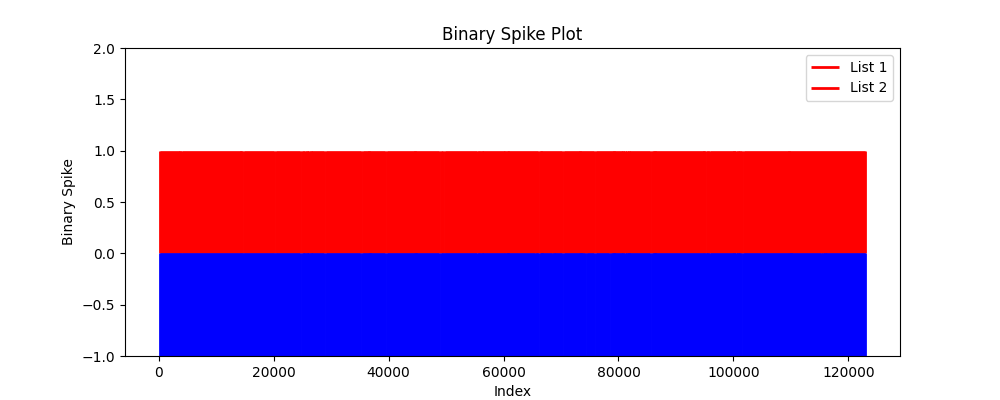

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = PythonMUPulses[14]
list2 = MatlabMUPulse[16]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()